In [1]:
import pandas as pd
from Bio import SearchIO
from Bio import SeqIO
from Bio import Phylo
import os
import re
import glob
import regex

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

from multiprocessing import Pool
from functools import partial
import numpy as np

# from check_seq import check_seq
# from check_seq import conditional_check_seq

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Parse HMM output and grab hits; hits must meet the following criteria
- positive bit score
- full sequence evalue must be sigarsicant (<0.01)
- best domain evalue should be sigarsicant (<0.01)
    - otherwise flagged for manual review to check if it is distant homolog or just short repeats

### Store hits in feather file

In [2]:
import pandas as pd
from Bio import SearchIO
import re
import glob
import sys

# get folder
#dir = sys.argv[1]
dir = 'archaea'
# Get taxonomy from GTDB, https://data.ace.uq.edu.au/public/gtdb/data/releases/latest/
    # NCBI taxonomy from metadata files

GTDB_taxonomy = pd.read_csv('GTDB_taxonomy.tsv', header = None, sep = '\t', names=['GenomeID', 'GTDB'])


'''Parse HMM output and grab hits; hits must meet the following criteria
- positive bit score
- full sequence evalue must be sigarsicant (<0.01)
- best domain evalue should be sigarsicant (<0.01)
    - otherwise flagged for manual review to check if it is distant homolog or just short repeats

Store hits in feather file'''

# Create empty lists
result_target = []
query_id = []
hit_id = []
evalue = []
best_domain_evalue = []
bitscore = []
bias = []
location = []
alength = []
slength = []
flag1 = []
flag2 = []

def append_hit(genomeID, gene, item):
    result_target.append(genomeID)
    query_id.append(gene)
    hit_id.append(item.id)
    evalue.append(item.evalue)
    best_domain_evalue.append(item.hsps[0].evalue)
    bitscore.append(item.bitscore)
    bias.append(item.bias)
    s = r'# ([0-9]+) # ([0-9]+)'
    location.append(re.match(s, item.description).group(1) + "-" + re.match(s, item.description).group(2))
    alength.append(item.hsps[0].aln_span)
    slength.append(int(re.match(s, item.description).group(2))-int(re.match(s, item.description).group(1)))

# Parse through files in output directory

for file in glob.glob(f'../results/{dir}/hmmsearch_results/*.out'):

    # RegEx for the GenomeID (double checking that file is really a genome)
    try:
        s = r'([\w]+_[\w]+_[\d]+\.[\d])'
        genomeID = re.search(s, file).group()
    except:
        continue

    # Parse file using SearchIO/HmmerIO
    for result in SearchIO.parse(file, 'hmmer3-text'):
        for item in result.hits:

            # grab gene name
            s = r'([a-zA-Z]+)' # ex. arsHDK
            gene = re.findall(s, result.id)[0]

            # Check for positive bitscore and append the data to the corresponding lists
            if item.bitscore > 0 and item.evalue < 0.01:
                # append hits
                append_hit(genomeID, gene, item)

                # check if full seq and best domain e-val are sigarsicant
                if item.hsps[0].evalue < 0.01:
                    flag1.append(0)
                else:
                    # check if "full sequence Eval is sig but best domain is not, keep only if the target sequence "a multidomain remote homolog; but be wary, and watch out for the case where it’s just a repetitive sequence"
                    flag1.append(1)

                # check if bitscore >> bias (same order of magnitude) as bitscore
                if item.bias != 0 and item.bitscore/item.bias > 10:
                    flag2.append(0)
                else:
                    flag2.append(1)
                
# create and store dataframe
hits = pd.DataFrame({'GenomeID': result_target, 'Gene': query_id, 'Hit': hit_id, 
                     'E-value': evalue, 'Best Domain E-value': best_domain_evalue, 'Bit Score': bitscore, 'Bias': bias,
                     'Location': location, 'Alignment Length': alength, 'Sequence Length': slength, 
                     'Flag_Eval': flag1, 'Flag_Bias': flag2})

# add taxonomy info
hits = pd.merge(hits, GTDB_taxonomy, on = "GenomeID", how = "left")

# save as feather file
hits.to_feather(f'../results/{dir}/hits.feather')

## Parse hits to find best gene match
- Since arsDK are distantly related, they almost always both appear as hits for each other (how can I word this better)
- To properly assign the correct gene, select the hit with the highest bitscore/lowest evalue
- then consider operon organization
    - if more than 10 genes away (need a reference pt for this number, look for other hits)
- Keep genes from genomes that contain all arsHDK
- Store other less promising hits, for later validation

### Output top hits as feather file

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from itertools import combinations
from cluster_pos import cluster_pos

# get parsed hmm results
hits = pd.read_feather('../results/archaea/hits.feather')

# save "contig" as col
hits['contig'] = hits['Hit'].str.split('_').str[:-1].str.join('_') 

# multi-index to cluster by genome, contig
hits.set_index(['GenomeID', 'contig'], inplace = True)
hits.sort_index(inplace = True)
hits.sort_values(by=['GenomeID', 'contig', 'Hit', 'E-value'], inplace=True) # drop duplicate hits, but keep most sig e-value
hits.drop_duplicates(inplace = True, subset=['Hit', 'Gene'], keep='first')

# filter for genome, contig with at least 3 unique genes (arsRBC)
filtered_ars = hits.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Gene'].nunique() >= 3)

filtered_ars2 = filtered_ars.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Hit'].nunique() >= 3)

genomes_to_keep = pd.DataFrame(columns = filtered_ars2.columns)
genomes_to_keep['gene_cluster'] = 0

# iterate through each genome and contig
for genome in filtered_ars2.index.get_level_values(0).unique(): # iterate through each genome
    for contig in filtered_ars2.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

        tmp = filtered_ars2.loc[(genome, contig)]

        # only keep numbers that have clusters >= 3 (clusters must be within 15 genes)
        pos_clusters = cluster_pos(tmp.Hit.unique())

        # for each cluster, find the best combination of genes (min e-value)
        for cl in pos_clusters:
            pos = [contig + '_' + str(p) for p in cl]
            no_pos = len(pos)

            # need at least 3 genes to continue
            if no_pos < 3:
                continue

            # only keep hits that are in the cluster
            tmp2 = tmp[tmp.Hit.isin(pos)].reset_index()

            # check if the cluster has at least 3 unique genes
            if tmp2.Gene.nunique() >= 3:
                genomes_to_keep = pd.concat([genomes_to_keep, tmp2])

# filter for genomes to keep
genomes_to_keep.set_index(['GenomeID', 'contig'], inplace = True)
genomes_to_keep.to_feather(f'../results/archaea/hits.feather')
genomes_to_keep.to_csv(f'../results/archaea/hits.csv')


how many genomes only have arsDK?
How many genomes/contigs have multiple arsHDK motifs?
How many genes have both arsDK together --> i.e. no stop codon --> do they have two separate high scoring domains?

## Validate hits as correct arsHDK matches by checking for the presence of CDD's conserved features
- For arsD check for P-cluster and FeMoCo binding residues (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01976)
- For arsK check for P-cluster binding residues (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01974)
- For arsH check for active site, Fe-S cluster (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=349759)

In [ ]:
# align hits

from Bio import AlignIO

# grab both archaea + bacteria hits
arsA_archaea = pd.read_feather('../results/archaea/arsA.feather')
# ars = arsA_archaea.copy()
arsA_bacteria = pd.read_feather('../results/bacteria/arsA.feather')
ars = pd.concat([arsA_archaea, arsA_bacteria])

ars.reset_index(inplace = True)
ars.set_index(['GenomeID'], inplace = True)
ars['Seq'] = ''

# separate by annotation
arsA = ars[ars.Gene == 'arsA']
arsB = ars[ars.Gene == 'arsB']

gene_list = [arsA, arsB]
gene_names = ['arsA', 'arsB']

# get fasta sequences for each gene & export to fasta
for gene, name in zip(gene_list, gene_names):
    print(name)
    records = []
    for genome,hit in gene.iterrows():
        hit = hit.Hit
        print(genome)
        file = glob.glob(f"../all_rep_proteins_aa/*/{genome}_protein.faa")[0]

        for result in SeqIO.parse(file, "fasta"):
            if result.id == hit:
                # store seq
                gene.loc[genome, 'Seq'] = str(result.seq)
                # convert to seqrecord
                record = SeqRecord(Seq(result.seq), id=genome, description=hit)
                records.append(record)
                # exit loop once sequence is found
                break
        
    # Write the records to a FASTA file
    with open(name + ".fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

# align fasta files
for gene in ['arsA']:
    print(gene)
    num = eval(f"int({gene}.shape[0]/2000)+1") # how many splits
    os.system(f"seqtk split -n {num} {gene}_split {gene}.fasta") # split fasta file
    for i in range(num):
        print(i+1)
        if i+1 < 10:
            os.system(f"seqtk subseq ../input-files/arsA_C113_172_422_all_seqs.fasta ref_seq.ids >> {gene}_split.0000{i+1}.fa") # add reference sequences
            os.system(f"mafft --auto --quiet ../results/{gene}_split.0000{i+1}.fa > ../results/{gene}_split.0000{i+1}.aln")
        else:
            os.system(f"seqtk subseq ../input-files/arsA_C113_172_422_all_seqs.fasta ref_seq.ids >> {gene}_split.000{i+1}.fa") # add reference sequences
            os.system(f"mafft --auto --quiet ../results/{gene}_split.000{i+1}.fa > ../results/{gene}_split.000{i+1}.aln")

arsA
nan


IndexError: list index out of range

In [77]:
# check for conserved residues
from Bio import AlignIO
def check_gene(gene, ref_seq, important_residues, passing_score, p=False):

    alignment = AlignIO.read(f"{gene}.aln", "fasta")

    for record in alignment:
        if ref_seq in record.description:
            aln = record.seq
            break

    # map important cols in aln to ref_seq
    residue_to_alignment = {}
    residue_idx = 0  # index in original (ungapped) sequence
    col2res = {}

    for aln_idx, char in enumerate(aln):
        if char != '-':
            residue_idx += 1
            if residue_idx in important_residues:
                residue_to_alignment[residue_idx] = aln_idx
                col2res[aln_idx] = aln[aln_idx]
                
            # early stop if we've found everything
            if len(residue_to_alignment) == len(important_residues):
                break

    # print the corresponding residues in the original sequence
    if p:
        for residue, aln_idx in residue_to_alignment.items():
            print(f"Residue {residue} corresponds to alignment index {aln_idx}: {aln[aln_idx]}")

    # store in dataframe        
    acc = [result.id for result in alignment]
    seqs = [list(str(result.seq)) for result in alignment]
    hits = [result.description.split(' ')[-1] for result in alignment]

    pssm = pd.DataFrame(seqs, index = acc)

    pssm = pssm.iloc[:, list(residue_to_alignment.values())]
    pssm['hit'] = hits
    pssm['contig'] = pssm['hit'].str.split('_').str[:-1].str.join('_')
    
    # check if cols contain correct residue for function
    def check_res(row):
        score = 0
        for col in residue_to_alignment.values():
            if row[col] == aln[col]:
                score += 2
                if aln[col] == 'C': # higher weight for correct C
                    score += 1
            elif aln[col] == 'C': # if ref seq is C, must also be C
                continue
            elif row[col] != '-': # greater penalty for gap than incorrect residue
                score += 1
        if score >= passing_score:
            return score
        else:
            return np.nan
        #return score

    pssm['score'] = pssm.apply(check_res, axis = 1)
    pssm.dropna(subset = ['score'], inplace = True)
    # rename cols
    pssm.rename(columns = col2res, inplace = True)

    return pssm


In [140]:
# arsA

important_residues_arsA = [113, 172, 422] # CCC in e. coli

ref_seq_arsA = 'tr|A0A2A5MC03|A0A2A5MC03_9ENTR'

passing_score = 9

# initialize dataframe
arsA_checked = check_gene('../results/fasta_splits/arsA_split.00001', ref_seq_arsA, important_residues_arsA, passing_score, p=True)

for file in glob.glob(f'../results/fasta_splits/arsA_split.000*.aln'):
    if file == '../results/fasta_splits/arsA_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_arsA, important_residues_arsA, passing_score)
    arsA_checked = pd.concat([arsA_checked, new])

arsA_checked.drop_duplicates(subset = ['hit'], inplace = True)
arsA_checked.set_index(['hit'], append= True, inplace = True)

print(str(len(arsA_checked)) + " arsA seqs")

Residue 113 corresponds to alignment index 3879: C
Residue 172 corresponds to alignment index 4702: C
Residue 422 corresponds to alignment index 6333: C
598 arsA seqs


In [214]:
# append updated annotation (based on conserved residue matching) to ars files
# grab both archaea + bacteria hits
arsA_archaea = pd.read_feather('../results/archaea/arsA.feather')
arsA_bacteria = pd.read_feather('../results/bacteria/arsA.feather')
ars = pd.concat([arsA_archaea, arsA_bacteria])

ars.reset_index(inplace = True)
ars.set_index(['GenomeID', 'Hit'], inplace = True)
ars['Seq'] = ''
ars['residue_match'] = ''
ars['backup_match'] = ''

ars.sort_index(inplace = True)

# update residue match column in ars df
for gene in 'A':
    for genome, cols in eval(f"ars{gene}_checked.iterrows()"):
        ars.loc[(genome[0], genome[1]), 'residue_match'] = "ars" + gene

# filter to get hits that passed residue matching
ars.reset_index(level = 'Hit', inplace = True)
ars.set_index('contig', append=True, inplace = True)

arsA = ars[(ars.residue_match == 'arsA') & (ars.Gene == 'arsA') & (ars['Alignment Length'] > 400)]
arsB = ars.loc[arsA.index]
arsB = arsB[arsB.Gene == 'arsB'] # only keep arsB hits with true arsA

ars = pd.concat([arsA, arsB])
ars.sort_index(inplace = True)

ars.to_csv('../results/ars_rescheck_nofilt_07212025.csv')

In [250]:
ars = pd.read_csv('../results/arsB-only.csv', index_col=[0,2])
ars

contig                 Hit       E-value  \
GenomeID           Gene                                                    
GB_GCA_000016605.1 arsB     CP000682.1     CP000682.1_2180  1.200000e-23   
GB_GCA_000145985.1 arsB     CP002098.1     CP002098.1_1599  8.700000e-22   
                   arsB     CP002098.1      CP002098.1_575  2.700000e-10   
                   arsB     CP002098.1      CP002098.1_576  3.900000e-07   
                   arsB     CP002098.1      CP002098.1_578  9.800000e-24   
...                                ...                 ...           ...   
RS_GCF_963378105.1 arsB  NZ_OY726398.1  NZ_OY726398.1_2494  3.700000e-44   
                   arsB  NZ_OY726398.1  NZ_OY726398.1_3935  1.000000e-42   
                   arsB  NZ_OY726398.1  NZ_OY726398.1_2494  2.700000e-37   
                   arsB  NZ_OY726398.1  NZ_OY726398.1_3935  1.100000e-53   
                   arsB  NZ_OY726398.1  NZ_OY726398.1_2494  4.300000e-45   

                         Best Domain E-value  Bit Score  Bias  \
GenomeID           Gene                                         
GB_GCA_000016605.1 arsB         1.300000e-23       80.5  25.6   
GB_GCA_000145985.1 arsB         1.200000e-21       74.2  45.2   
                   arsB         3.300000e-10       36.3  16.9   
                   arsB         4.900000e-07       25.9  12.8   
                   arsB         1.200000e-23       80.6  38.8   
...                                      ...        ...   ...   
RS_GCF_963378105.1 arsB         4.100000e-44      149.0  36.8   
                   arsB         1.400000e-42      144.5  22.7   
                   arsB         3.100000e-37      126.7  33.9   
                   arsB         1.200000e-53      180.5  28.6   
                   arsB         4.800000e-45      152.1  35.9   

                                Location  Alignment Length  Sequence Length  \
GenomeID           Gene                                                       
GB_GCA_000016605.1 arsB  2004741-2005958               409             1217   
GB_GCA_000145985.1 arsB  1474046-1475545               447             1499   
                   arsB    521539-522315               250              776   
                   arsB    522343-522825               149              482   
                   arsB    524588-525889               420             1301   
...                                  ...               ...              ...   
RS_GCF_963378105.1 arsB  2713045-2714334               434             1289   
                   arsB  4201403-4202653               426             1250   
                   arsB  2713045-2714334               435             1289   
                   arsB  4201403-4202653               429             1250   
                   arsB  2713045-2714334               435             1289   

                         Flag_Eval  Flag_Bias  \
GenomeID           Gene                         
GB_GCA_000016605.1 arsB          0          1   
GB_GCA_000145985.1 arsB          0          1   
                   arsB          0          1   
                   arsB          0          1   
                   arsB          0          1   
...                            ...        ...   
RS_GCF_963378105.1 arsB          0          1   
                   arsB          0          1   
                   arsB          0          1   
                   arsB          0          1   
                   arsB          0          1   

                                                                      GTDB  
GenomeID           Gene                                                     
GB_GCA_000016605.1 arsB  d__Archaea;p__Thermoproteota;c__Thermoprotei_A...  
GB_GCA_000145985.1 arsB  d__Archaea;p__Thermoproteota;c__Thermoprotei_A...  
                   arsB  d__Archaea;p__Thermoproteota;c__Thermoprotei_A...  
                   arsB  d__Archaea;p__Thermoproteota;c__Thermoprotei_A...  
                   arsB  d__Archaea;p__Thermoproteota;c__Thermoprotei

In [ ]:
# # want to only keep contigs w/ arsHDKEN

# from cluster_pos import cluster_pos

# # make sure gene clusters have at least arsHDK
# def gene_check(genes):
#     if genes.__contains__('arsH'):
#         if genes.__contains__('arsD'):
#             if genes.__contains__('arsK'):
#                 return True

# # multi-index to cluster by genome, contig
# ars = pd.read_csv('ars_rescheck_nofilt_04292025.csv')
# ars.reset_index(inplace = True)
# ars.set_index(['GenomeID', 'contig'], inplace = True)
# ars.sort_index(inplace = True)
# ars.drop_duplicates(inplace = True)

# # filter for genome, contig with at least 3 unique genes (arsHDKENB)
# filtered_ars = ars.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Gene'].nunique() >= 3)

# # make sure these 3 unique genes are not the same hit (i.e. not the same gene in reference genome)
# filtered_ars2 = filtered_ars.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Hit'].nunique() >= 3)

# genomes_to_keep = []
# # iterate through each genome and contig
# for genome in filtered_ars2.index.get_level_values(0).unique(): # iterate through each genome
#     for contig in filtered_ars2.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

#         tmp = filtered_ars2.loc[(genome, contig)]

#         # only keep numbers that have clusters >= 3
#         pos_clusters = cluster_pos(tmp.Hit.unique(), 20)

#         # for each cluster, find the best combination of genes (min e-value)
#         for ind, cl in enumerate(pos_clusters):
#             pos = [contig + '_' + str(p) for p in cl]
#             no_pos = len(pos)
            
#             # need at least 3 genes to continue
#             if no_pos < 3:
#                 continue

#             # only keep hits that are in the cluster
#             tmp2 = tmp[tmp.Hit.isin(pos)]

#             # only keep hits that are in the cluster
#             tmp2 = tmp[tmp.Hit.isin(pos)].reset_index()

#             # check if all genes are present
#             if gene_check(tmp2.residue_match.to_list()):
#                 # get index
#                 items = [(genome, contig, hit) for hit in tmp2.Hit]
#                 genomes_to_keep.extend(items)

# # filter for genomes to keep
# filtered_ars2.set_index(['Hit'], append = True, inplace = True)
# filtered_ars2 = filtered_ars2.loc[genomes_to_keep]
# filtered_ars2.sort_index(inplace = True)

# #clean up cols
# filtered_ars2['Gene'] = filtered_ars2['residue_match']
# filtered_ars2 = filtered_ars2[['Gene', 'E-value', 'Bit Score', 'Location', 'Alignment Length', 'Sequence Length', 'GTDB']]
# filtered_ars2.drop_duplicates(inplace = True)

# # # export 
# # filtered_ars2.to_feather('ars_final_04292025.feather')
# # filtered_ars2.to_csv('ars_final_04292025.csv')

In [ ]:
# final-fasta-export.py

ars = pd.read_csv('../results/ars_rescheck_nofilt_07212025.csv', index_col=[0,2])

arsB_only = pd.read_csv('../results/arsB-only.csv')
arsB_only.set_index(['GenomeID', 'Hit'], inplace = True)

# export fasta files
arsA = ars[(ars.Gene == 'arsA')]
arsB = ars[(ars.Gene == 'arsB')]

gene_list = [arsA, arsB, arsB_only]
gene_names = ['arsA', 'arsB', 'arsB_only']

# get fasta sequences for each gene & export to fasta
for gene, name in zip(gene_list, gene_names):
    print(name)
    records = []

    for genome,contig in gene.iterrows():
        print(genome)
        file = glob.glob(f"../../GTDB/all_rep_proteins_aa/*/{genome[0]}_protein.faa")[0]
        for result in SeqIO.parse(file, "fasta"):
            if result.id == genome[-1]:
                # store seq
                gene.loc[genome, 'Seq'] = str(result.seq)
                # convert to seqrecord
                record = SeqRecord(result.seq, id=genome[0], description=genome[-1])
                records.append(record)
                # exit loop once sequence is found
                break
    print(len(records))    
    # Write the records to a FASTA file
    with open("../results/checked_" + name + "07212025.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")


arsA
('GB_GCA_000027065.2', 'FN543096.1_25')


IndexError: list index out of range

In [223]:
# export in genomic-centric organization
ars = pd.read_csv('../results/ars_rescheck_nofilt_07212025.csv')
ars.reset_index(inplace = True)

# load GTDB metadata
GTDB_metadata = pd.read_csv('GTDB_metadata.tsv', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# def for sorting gene order
def sort_order(g):
    order = ['A', 'B']
    return order.index(g)

# get gene set (i.e. HDKEN)
ars['Gene'] = ars['Gene'].str.replace('ars', '')
ars['Gene set'] = ars[['GenomeID','contig','Gene']].groupby(['GenomeID','contig'])['Gene'].transform(lambda x: ''.join(sorted(x, key=sort_order)))
# get contig positions (i.e. 1,2,3)
ars['index'] = ars['Hit'].str.split('_').str[-1]
ars['Position'] = ars[['GenomeID','contig','index']].groupby(['GenomeID','contig'])['index'].transform(lambda x: ','.join(sorted(x)))

# group by genome, contig and save
ars = ars[['GenomeID', 'contig', 'Gene set', 'Position', 'GTDB']]
ars = ars.groupby(['GenomeID','contig']).first()
ars.reset_index(level=['GenomeID','contig'], inplace = True)

#merge dataframes to include accession, metadata, and sequences (for filtering)
ars = pd.merge(ars, GTDB_metadata, left_on = 'GenomeID', right_on = 'accession', how = 'left').drop(columns = ['accession', 'gtdb_taxonomy'])

ars['An/aerobic'] = ''
ars['Thermophile'] = ''
ars['Culture'] = ''
ars['Reference'] = ''
ars.sort_index(inplace = True)
ars.set_index(['GenomeID', 'contig'], inplace = True)

#ars.to_csv('ars_genomes_07212025.csv') #--> do not overwrite! contains hand typped info!!!

In [225]:
ars.to_csv('ars_genomes_07212025.csv') #--> do not overwrite! contains hand typped info!!!

### Assessing operon organization (what neighbors arsHDKEN clusters)

In [ ]:
# operon organization

from cluster_pos import cluster_pos

# grab checked ars
ars = pd.read_csv('../results/ars_rescheck_nofilt_07212025.csv')

#multi-index to cluster by genome, contig
ars.reset_index(inplace = True)
ars.set_index(['GenomeID', 'contig'], inplace = True)
ars.sort_index(inplace = True)
ars.drop_duplicates(inplace = True)

# iterate through each genome and contig
for genome in ars.index.get_level_values(0).unique(): # iterate through each genome
    for contig in ars.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

        tmp = ars.loc[(genome, contig)]

        # get clusters
        pos_clusters = cluster_pos(tmp.Hit.unique(), 40)
        # get positions within +/-12 genes of center 
        for cl in pos_clusters:
            middle = cl[len(cl)//2] # center of cluster
            pos = [middle+num for num in range(-12,13) if middle+num > 0]
            acc = [contig + '_' + str(p) for p in pos] # get acc

            # write list items into a .txt file
            os.system("rm seqs.txt")
            with open("seqs.txt", "w") as f:
                for item in acc:
                    f.write(f"{item}\n")

            # save subsets as fasta
            try:
                file = glob.glob(f"../../GTDB/all_rep_proteins_aa/*/{genome[0]}_protein.faa")[0]
                os.system(f"seqtk subseq {file} seqs.txt > ../operon_org/input-fastas/{genome}_{contig}_operon.fasta")
            except:
                continue

GB_GCA_000027065.2 FN543096.1
GB_GCA_000302695.1 AMFN01000003.1
GB_GCA_000752035.1 CCFE01000018.1
GB_GCA_000963575.1 CP011077.1
GB_GCA_001564065.1 LKNA01000012.1
GB_GCA_001636495.1 KV440964.1
GB_GCA_001655195.1 LPNY01000021.1
GB_GCA_002261155.1 NKXN01000068.1
GB_GCA_002400675.1 NVQY01000117.1
GB_GCA_002441445.1 DJWC01000119.1
GB_GCA_002733685.1 NVWN01000027.1
GB_GCA_003457145.1 DMSR01000278.1
GB_GCA_003559375.1 PWLN01000067.1
GB_GCA_003563455.1 PWRV01000310.1
GB_GCA_004153165.1 SEMD01000007.1
GB_GCA_004153195.1 SEMC01000021.1
GB_GCA_004153225.1 SEMB01000007.1
GB_GCA_004195035.1 SGBD01000001.1
GB_GCA_004298015.1 SCSE01000033.1
GB_GCA_007116585.1 SKIE01000019.1
GB_GCA_007123715.1 SKKO01000091.1
GB_GCA_007123775.1 SLGK01000236.1
GB_GCA_007131625.1 SLQC01000177.1
GB_GCA_007132495.1 SLOL01000096.1
GB_GCA_007134085.1 SLLL01000035.1
GB_GCA_007135335.1 SLJB01000047.1
GB_GCA_007693295.1 REDT01000194.1
GB_GCA_007693395.1 REDS01000104.1
GB_GCA_008180335.1 VTEF01000005.1
GB_GCA_009363175.1 CP04520

In [ ]:
# plot operon-org of annotated genes
import requests

arsAB = pd.read_csv('../results/ars_rescheck_nofilt_07212025.csv', index_col=[0,1])

gene_abv = {'K00532': 'hydA', 'K07486':'tns', 'K07485':'tns', 'K07487':'tns', 'K13819': 'arsU'} # store ko2gene
gene_data = pd.DataFrame(columns = ['genome', 'contig', 'query_id', 'gene', 'ko_number', 'start', 'end', 'orientation'])
#gene_data.set_index(['query_id'], inplace = True)

def ko2gene(ko):
    try:
        return gene_abv[ko]
    except:
        url = f"https://rest.kegg.jp/get/ko:{ko}"
        r = requests.get(url)
        for line in r.text.split("\n"):
            if line.startswith("SYMBOL"):
                gene = line.split()[-1]
                gene_abv[ko] = gene
                return gene

# grab annotation files
for file in glob.glob(f"../operon-org/microbeannotator/annotation_results/*.annot")[0:5]:
    # convet ko_number to gene abv
    annot = pd.read_csv(file, sep = '\t', index_col=0)
    annot['gene'] = annot['ko_number'].apply(ko2gene)

    # grab genome and contig from file name
    s = r'([A-Z_]+[A-Z0-9.]+)_([A-Z_]*[A-Z0-9.]+)'
    genome = re.search(s, file).group(1)
    contig = re.search(s, file).group(2)

    # grab start, end, orientation of each gene
    input = glob.glob(f"../operon-org/input-fastas/{genome}_{contig}_operon.fasta")[0]
    for result in SeqIO.parse(input, "fasta"):
        start = int(result.description.split('# ')[1])
        end = int(result.description.split('# ')[2])
        orientation = int(result.description.split('# ')[3])
        if result.id in annot.index:
            annot.loc[result.id, 'start'] = start
            annot.loc[result.id, 'end'] = end
            annot.loc[result.id, 'orientation'] = orientation

    # add arsA, arsB hits to annot
    for row in arsAB.loc[(genome, contig)].iterrows():
        annot.loc[row[1].Hit, 'gene'] = row[1].Gene
        annot.loc[row[1].Hit, 'start'] = int(row[1].Location.split('-')[0])
        annot.loc[row[1].Hit, 'end'] = int(row[1].Location.split('-')[1])
        annot.loc[row[1].Hit, 'orientation'] = 1 # BUG:CANNOT KNOW ORIENTATION

    # set genome and contig
    annot['genome'] = genome
    annot['contig'] = contig

    annot.reset_index(inplace = True)
    gene_data = pd.concat([gene_data, annot[['genome', 'contig', 'query_id', 'gene', 'ko_number', 'start', 'end', 'orientation']]])
gene_data.to_csv('../operon-org/operon-org-plot-data-test.csv')

In [105]:
# plot
from pygenomeviz import GenomeViz

# open microbeannotator results
gene_data = pd.read_csv('../operon-org/operon-org-plot-data-test.csv', index_col=[1,2])
genome_list = gene_data.index.get_level_values(0).unique().to_list()

gv = GenomeViz(feature_track_ratio=0.7)
gv.set_scale_bar(labelsize=20)
# gv.set_scale_xticks(labelsize=20)

for genome in genome_list:
    genes = gene_data.loc[(genome)].gene.to_list()
    starts = gene_data.loc[(genome)].start.to_list()
    ends = gene_data.loc[(genome)].end.to_list()
    orientations = gene_data.loc[(genome)].orientation.to_list()

    track = gv.add_feature_track(genome, (int(min(starts)), int(max(ends))))
    for idx, gene in enumerate(genes):
        if gene == 'arsA':
            color = '#156082'
        elif gene == 'arsR':
            color = '#76C0AF'
        elif gene == 'arsC':
            color = '#98A2C2'
        elif gene == 'arsB':
            color = '#C85D2B'
        elif gene == 'arsD':
            color = 'orange'
        else:
            color = '#FFFFFF'
            
        track.add_feature(
            int(starts[idx]),
            int(ends[idx]),
            int(orientations[idx]),
            plotstyle='bigarrow',
            arrow_shaft_ratio=0.7,
            fc = color,
            lw = 1,
            label = gene,
            text_kws=dict(rotation=0, vpos="bottom", hpos="center"))
        
    #track.add_sublabel()#int(min(starts)), int(max(ends))), fontsize=20)

gv.savefig("../operon-org/test.png")

OLD Below

In [ ]:
# read fasta file merged_arsH.faa and save as df

# arsH = list(SeqIO.parse("clustered_arsH_rep_seq.fasta", "fasta"))
# arsH = pd.DataFrame([(record.id, str(record.seq)) for record in arsH], columns = ['GenomeID', 'Seq'])

arsD_list = list(SeqIO.parse("ko_arsD.fasta", "fasta"))
arsD_list = pd.DataFrame([(record.id, str(record.seq)) for record in arsD_list], columns = ['GenomeID', 'Seq'])
arsD_list = arsD_list.GenomeID

# arsD = list(SeqIO.parse("clustered_arsD_rep_seq.fasta", "fasta"))
# arsD = pd.DataFrame([(record.id, str(record.seq)) for record in arsD], columns = ['GenomeID', 'Seq'])

# arsK = list(SeqIO.parse("clustered_arsK_rep_seq.fasta", "fasta"))
# arsK = pd.DataFrame([(record.id, str(record.seq)) for record in arsK], columns = ['GenomeID', 'Seq'])


In [ ]:
# final
# CDD conserved features and error tolerance

arsD_FeMoCo = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H', 5)
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
arsD_FeMoCo_mod = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H', 10)
# for all other arsD check their length!
arsD_Pcluster = (r'C[A-Z]Y[A-Z]{20}P[A-Z]GC[A-Z]{64,65}C[A-Z]{30,31}G', 5)

arsK_Pcluster = (r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S', 7)

arsH_active = (r'KGGIGKS[A-Z]{24,36}KAD', 4)
arsH_FeS = (r'C[A-Z]{29,37}C[A-Z]G',2)

In [ ]:
# check seeds seq

from multiprocessing import Pool
from functools import partial
import numpy as np

from check_seq import check_seq
from check_seq import conditional_check_seq

#arsH

# #pass constant arguments to check_seq
# feature = arsH_active
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, arsH.Seq)

# arsH.loc[:, 'match1'] = np.array(results)

# # match FeS cluster binding site (binds Fe4-S4 cluster)
# feature = arsH_FeS
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, arsH.Seq)
# arsH.loc[:, 'match2'] = np.array(results)

# print('arsH done')

# match arsD MoFeCo binding site
feature = arsD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.loc[:, 'match1'] = np.array(results)

# match arsD MoFeCo binding site
feature = arsD_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.loc[:, 'match2'] = np.array(results)

print('typical arsD done')

# match arsD MoFeCo binding site
feature = arsD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)

# Use Pool to apply the function
with Pool(4) as p:
    results = p.starmap(conditional_check_seq, zip(arsD.Seq, arsD.match1))

# match arsD MoFeCo binding site
feature = arsD_FeMoCo_mod
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.match2 = results

print('arsD done')

# # match arsD MoFeCo binding site --> all arsK pass
# feature = arsK_Pcluster
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, arsK.Seq)


# arsK.loc[:, 'match1'] = np.array(results)

# print('arsK done')

typical nifD done
nifD done


In [ ]:
# print rows where arsH.match1 is false
# at 5, all but 2 rows fail rsin:B6N60_04474, dou:BMF77_01967
# failed_arsH = arsH.loc[arsH.match1 != True]

# failed = list(failed_arsH.Seq)

arsH_active = (r'KGGIGKS[A-Z]{24,36}KAD', 5)

arsK_Pcluster = (r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S', 6)

arsD_FeMoCo = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H', 6)
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
arsD_FeMoCo_mod = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H', 10)

seq = 'MTPPENQNIIEERKELIKEVLDAYPDKAKKKREKHLSVYEEGKSDCGVKSNIKSLPGVMTARGCAYAGSKGVVWGPIKDMIHISHGPVGCGYWSWSGRRNYYIGTTGIDTFGTMHFTSDFQERDIVFGGDKKLVKLIQELDVLFPLNRGVSIQSECPIGLIGDDIEAVARKTSKEIGKPVVPVRCEGFRGVSQSLGHHIANDMVRDWVFTRADQAKKDGTLQFEGTPYDVAIIGDYNIGGDAWASRILLEEIGLRVVAQWSGDGTINEMLMTPNVKMNLIHCYRSMNYISRHMEEAYGIPCLNYDNVTMTDENIRQIAFYGKGGIGKSTTSQNTLAAMAEMGQRILIVGCDPKADSTRLMLHSKAQTTVLHLAAERGAVEDIEIEEVMLTGFRNVRCVESGGPEPGVGCAGRGIITAINFLEENGAYQDLDFVSYDVLGDVVCGGFAMPIREGKAQEIYIVTSGEMMAMYAANNIARGVLKYAHTGGVRLGGLICNSRNTDREIELIETLAKRLNTQMIHYVPRDNIVQHAELRRMTVNEYAPESNQANEYRILAQKIIDNKNLAIPTPIEMEELEELLIEFGILESDENAAKLVGKTAAEAPVS'

fuzzy_pattern = f'({arsK_Pcluster[0]}){{e<={arsK_Pcluster[1]}}}'

match = regex.search(fuzzy_pattern, seq, regex.BESTMATCH)

print(match)

<regex.Match object; span=(73, 192), match='WGPIKDMIHISHGPVGCGYWSWSGRRNYYIGTTGIDTFGTMHFTSDFQERDIVFGGDKKLVKLIQELDVLFPLNRGVSIQSECPIGLIGDDIEAVARKTSKEIGKPVVPVRCEGFRGVS', fuzzy_counts=(4, 0, 1)>


In [ ]:
# similar to final but in python file
from multiprocessing import Pool
from functools import partial
import numpy as np

from check_seq import check_seq

# arsH

# pass constant arguments to check_seq
feature = arsH_active
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsH.Seq)

arsH.loc[:, 'match1'] = np.array(results)

# match FeS cluster binding site (binds Fe4-S4 cluster)
feature = arsH_FeS
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsH.Seq)
arsH.loc[:, 'match2'] = np.array(results)

print('arsH done')

# match arsD MoFeCo binding site
feature = arsD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.loc[:, 'match1'] = np.array(results)

# match arsD MoFeCo binding site
feature = arsD_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.loc[:, 'match2'] = np.array(results)

print('typical arsD done')

# match arsD MoFeCo binding site
feature = arsD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)

# Use Pool to apply the function
with Pool(4) as p:
    results = p.starmap(conditional_check_seq, zip(arsD.Seq, arsD.match1))

# match arsD MoFeCo binding site
feature = arsD_FeMoCo_mod
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsD.Seq)
arsD.match2 = results

print('arsD done')

# match arsD MoFeCo binding site
feature = arsK_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, arsK.Seq)


arsK.loc[:, 'match1'] = np.array(results)
arsK = arsK.drop(columns = 'match2')

print('arsK done')

nifH done
typical nifD done
nifK done


What do I do with arsH and arsD seq that fail CDD criteria? (usually they are too short and only contain a portion of the gene)?
    - instead of hmmsearch with all NFixDB onlny use initial seeds seq?
    - def remove them from arsH (sequences that are long enough dont have correct residues)

In [ ]:
# finalized checks, e such that all seqs in clustered_ars_seq.fasta pass -- KEEP!!!

arsD_FeMoCo = r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H' # e<=4
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
arsD_FeMoCo_mod = r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H' #e<=8
# for all other arsD check their length!

arsD_Pcluster = r'C[A-Z]Y[A-Z]{20}P[A-Z]GC[A-Z]{64,65}C[A-Z]{30,31}G' # e<=5

arsK_Pcluster = r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S' # e<=8

arsH_active = r'KGGIGKS[A-Z]{24,36}KAD' # e<=2
arsH_FeS = r'C[A-Z]{29,37}C[A-Z]G' # e<=2

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# grab sequences from same genomes and string together before clustering

# join df on genomeID

ars = arsH.merge(arsD, on = 'GenomeID', how = 'inner', suffixes = ('_H', '_D'))
ars = ars.merge(arsK, on = 'GenomeID', how = 'inner', suffixes = ('_K', '_K'))
ars['Full Seq'] = ars.Seq_H + ars.Seq_D + ars.Seq


# Convert the DataFrame to SeqRecord objects
records = []
for index, row in ars.iterrows():
    record = SeqRecord(Seq(row['Full Seq']), id=index, description="arsHDK")
    records.append(record)

# Write the records to a FASTA file
with open("filteredhits.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")


In [ ]:
# now I need to cluster the hits by sequence similarity before predicting their structures
file = 'clustered_filteredhits_30_rep_seq.fasta'

# get list of ids from fasta file
ids = []
for record in SeqIO.parse(file, "fasta"):
    ids.append(record.id)

clustered_ars = ars[ars.index.isin(ids)]

clustered_ars = clustered_ars[['Seq_H', 'Seq_D', 'Seq']]

## Extra functions!

In [ ]:
# taxa counter
ars = pd.read_feather('ars_final_04202025.feather')
ars['phylum'] = ars['GTDB'].str.split(';').str[1]
ars['class'] = ars['GTDB'].str.split(';').str[2]
ars['order'] = ars['GTDB'].str.split(';').str[3]
ars['family'] = ars['GTDB'].str.split(';').str[4]

phyla = ars['phylum'].value_counts()
print(phyla)

classes = ars['class'].value_counts()
print(classes)

phylum
p__Pseudomonadota      7029
p__Bacillota_A         5453
p__Desulfobacterota    2859
p__Bacteroidota        1311
p__Cyanobacteriota     1198
                       ... 
p__Nitrospirota_B         3
p__JACRDZ01               3
p__SZUA-182               3
p__UBA3054                3
p__Asgardarchaeota        3
Name: count, Length: 62, dtype: int64
class
c__Clostridia             5383
c__Gammaproteobacteria    3961
c__Alphaproteobacteria    2983
c__Cyanobacteriia         1190
c__Bacteroidia             861
                          ... 
c__Limnochordia              3
c__Methanomethylicia         3
c__SURF-8                    3
c__SZUA-365                  3
c__JACRHL01                  3
Name: count, Length: 144, dtype: int64


In [ ]:
# clean up newick file nodes = Species | Gene | GenomeID | Hit
import Bio.Phylo.NewickIO

def replace_char(string):
    # Replace the unwanted characters with an empty string
    return string.replace(' ', '_').replace(':', '_').replace('(', '_').replace(')', '_').replace(',', '_').replace(';', '_')

# export in genomic-centric organization
ars = pd.read_feather('ars_final_04292025.feather')
ars.reset_index(inplace = True)
ars.set_index(['GenomeID', 'Hit'], inplace = True)

# supposedly prevents decimal truncation by bio.phlyo...but doesn't work
Bio.Phylo.NewickIO._format_branch_length = lambda bl: f"{bl:.10f}" if bl is not None else ''

# load GTDB metadata --> comment out bc it takes a while to load
GTDB_metadata = pd.read_csv('GTDB_metadata.tsv', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# change names from treefiles to only be GTDB genomes
for gene in 'DK':
    file = f'../trees/ars{gene}_noOut_04292025/clustered_ars{gene}_noOut_rep_seq.trim.treefile'
    tree = Phylo.read(file, "newick")
    envs = []
    # Extract and print node names
    for clade in tree.get_terminals():
        if clade.name.startswith('WP_'):
            new_name = clade.name
        else:
            genome = clade.name.split('.')[0] + '.' + clade.name.split('.')[1][0]
            hit = '.'.join(clade.name.split('.')[1:])[2:]
            species = ars.loc[(genome, hit), 'GTDB'].split('__')[-1]
            gene_name = ars.loc[(genome, hit), 'Gene']
            env = GTDB_metadata.loc[GTDB_metadata.accession == genome, 'ncbi_isolation_source'].values[0]
            env = replace_char(env)
            new_name = f"{species}|{gene_name}|{env}|{genome}|{hit}"
        clade.name = new_name

    # Save the modified tree to a new file
    Phylo.write(tree, f'../trees/ars{gene}_noOut_04292025/ars{gene}_env.treefile', "newick")
    

In [39]:
# Get putative diazotroph genome names from LAMG results 
filteredhits_LAMG = list(SeqIO.parse("filteredhits_LAMG.fasta", "fasta"))
diazotrophs = [rec.name for rec in filteredhits_LAMG] 

# save as text file
with open("diazotrophs_LAMG.txt", "w") as f:
    for item in diazotrophs:
        f.write("%s\n" % item)

In [ ]:
# grab LAMG arsH seq 
arsH = pd.read_feather('filtered_arsH_LAMG.feather')

# Convert the DataFrame to SeqRecord objects
records = []
for index, row in arsH.iterrows():
    record = SeqRecord(Seq(row['Seq_H']), id=index, description="arsH_hmm")
    records.append(record)

# Write the records to a FASTA file
with open("filtered_arsH_LAMG.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")


(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   5.,   1.,   5.,
          5.,   2.,   1.,   1., 148.,  77., 178.,  82.,  54.,  40.,  25.,
         11.,  11.,   9.,   2.,   0.,   2.,   2.,   2.,   1.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

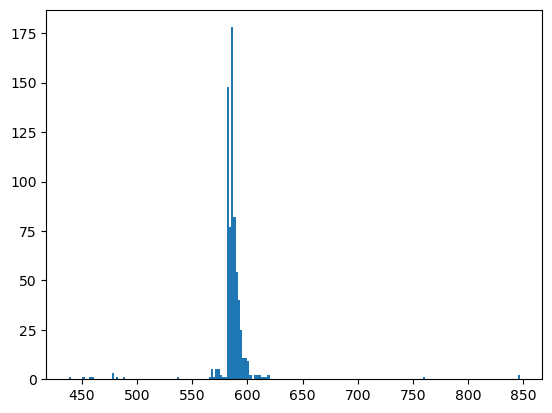

In [ ]:
from matplotlib import pyplot as plt

# how many hits have short aln len?
inputs = SeqIO.parse('../Ars-input/arsA_C113_172_422.fasta', 'fasta')
lens = [len(rec.seq) for rec in inputs]
plt.hist(lens, bins=200)


In [ ]:
# get thermophiles (for Mikhail)

# make sure seqs are in pruned tree (i.e. from nitrogenase clades)
tree = Phylo.read("Nitrogenase_clades.txt", "newick")

# Extract and print node names
nodes = []
for clade in tree.get_terminals():
    nodes.append(clade.name)

# uncluster seqs (using tsv files)
clusters = pd.read_csv('clustered_arsH_hmm_90_cluster.tsv', sep='\t', header=None, index_col = 0)
diazotrophs = clusters[clusters.index.isin(nodes)][1].to_list()

# load GTDB metadata
GTDB_metadata = pd.read_csv('GTDB_metadata.tsv', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# get arsD seqs
arsD_seqs = list(SeqIO.parse("filtered_arsD_LAMG.fasta", "fasta"))
arsD_df = pd.DataFrame([(record.id, str(record.seq)) for record in arsD_seqs], columns = ['GenomeID', 'Seq'])

# get arsK seqs
arsK_seqs = list(SeqIO.parse("filtered_arsK_LAMG.fasta", "fasta"))
arsK_df = pd.DataFrame([(record.id, str(record.seq)) for record in arsK_seqs], columns = ['GenomeID', 'Seq'])

# merge dataframes to include accession, metadata, and sequences (for filtering)
diazotrophs = pd.DataFrame(diazotrophs, columns = ['GenomeID'])
diazotrophs = pd.merge(diazotrophs, GTDB_metadata, left_on = 'GenomeID', right_on = 'accession', how = 'left').drop(columns = 'accession')
diazotrophs = pd.merge(diazotrophs, arsD_df, on = 'GenomeID', how = 'left')
diazotrophs = pd.merge(diazotrophs, arsK_df, on = 'GenomeID', how = 'left', suffixes=('_arsD', '_arsK'))

# keep species w/ "therm" or "heat" in taxonomy or isolation source
thermophiles = diazotrophs[diazotrophs.gtdb_taxonomy.str.contains('therm', case = False)]
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_taxonomy.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_taxonomy_unfiltered.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_country.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_country.str.contains('hot', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_isolation_source.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_isolation_source.str.contains('hot', case = False)]], ignore_index=True)

# remove duplicates
thermophiles = thermophiles.drop_duplicates(subset = 'GenomeID')

# export to csv
thermophiles.to_csv('thermophiles_LAMG.csv', index = False, sep='\t')

thermophiles

# awk '{print ">" $1 "|" $2; print $NF}' thermophiles_LAMG.csv > thermo_arsK.fasta
# awk '{print ">" $1 "|" $2; print $(NF-1)}' thermophiles_LAMG.csv > thermo_arsD.fasta

,GenomeID,gtdb_taxonomy,ncbi_country,ncbi_isolation_source,ncbi_taxonomy,ncbi_taxonomy_unfiltered,Seq_nifD,Seq_nifK
0,GB_GCA_903822005.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,none,lake water,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,MSTAIDDTRKIIDEVLEAYPEKVRKARARHLAPNDPAGSCASCKIQ...,MSKLKIKDHSELFLEPEYVDLFERKKEFEDACPDEEVKRVLDWTKT...
1,GB_GCA_937889015.1,d__Bacteria;p__Planctomycetota;c__Planctomycet...,none,metagenome,d__Bacteria;p__Planctomycetota;c__Planctomycet...,d__Bacteria;x__PVC group;p__Planctomycetota;c_...,MAPELIDPERVKQELLQAYPAKVGRKRAGQMVVNRKDTPGESPEIV...,MNLLKGAVRGSQENPTVLLRHTTPNVVERQALTINPAKTCQPIGAM...
2,GB_GCA_937924475.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,none,Mariane sediment,d__Bacteria;p__;c__;o__;f__;g__;s__,d__Bacteria;x__environmental samples;s__uncult...,MNTYTINKKNEEEIRHHRVCRSRGGESCAFDGAMIVLQPIADAVHL...,MFAISTTCMAEVIGDDLNAFIKKAKQQGVIPEQLPTPYSNTSSFTG...
3,GB_GCA_002339325.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,South Africa:Carltonville,water,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,MTRIIEQDTQRIVDEVLEVYPEKTKKERKKHLLANDPECSSSTCGL...,MKVQDHVKLYRREDYEKLFRDKREFECPYPEEEVKKVEEYTKTEEY...
4,GB_GCA_020725335.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,Russia: Borehole near Beyelii Yar in Tomsk,groundwater filtered on 0.22 m filters,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,MPRIIEQDTEKLIEEVLEIYPEKTRKERRKHLISNDPECTTSTCQL...,MKIMDHVELYKSEDYKELFENKKQFECPYSEEEVKKIEEYTKTEEY...
...,...,...,...,...,...,...,...,...
1978,GB_GCA_026418275.1,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ac...,Malaysia: Sungkai; Perak,alkaline hot spring water,d__Bacteria;p__Bacillota;c__Clostridia;o__;f__...,d__Bacteria;x__Terrabacteria group;p__Bacillot...,MPINIQNIEAATRENRLGAITGYHGTIKDLVSKATCCSLKNRERCF...,MTQLIEQLRHVCSLGALQSVLAIHRAVPILHAGPGCGQKLWSATGV...
1981,GB_GCA_026419705.1,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,Malaysia: Sungkai; Perak,alkaline hot spring water,d__Bacteria;p__Cyanobacteriota;c__Cyanophyceae...,d__Bacteria;x__Terrabacteria group;x__Cyanobac...,MIITQGKINELLSEPGCEHNHHTHGDKKNKACKQQAQPGAAQGGCA...,GCVAYFRTHLSRHYKEPFSAVSSSMTEDAAVFGGLNNMIEGLQVSY...
1983,GB_GCA_029266015.1,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,China:Yunnan province,native outdoor hot spring sediment,d__Bacteria;p__Bacteroidota;c__;o__;f__;g__;s__,d__Bacteria;x__FCB group;x__Bacteroidota/Chlor...,MKTKVTMDPERWKAEVLTKYPSKVAKKRAKSIVVNEGDEVKQIQAN...,MLLRHTTDKIIEREALTVNPAKTCQPVGAMYAALGIHGCLPHSHGS...
1984,GB_GCA_030389965.1,d__Bacteria;p__Chloroflexota;c__Chloroflexia;o...,Canada: near Kenora; Ontario; Lake 227; IISD-E...,Single colony of Candidatus Chlorohelix alloph...,d__Bacteria;p__Chloroflexota;c__;o__;f__;g__;s__,d__Bacteria;x__Terrabacteria group;p__Chlorofl...,MAVLKCDATIPERDKHILIKGEGQDGKCSIACNSATTPGDMTERGC...,MSTVVKQERAVSINPLRACAPIGAMLATFGIHGALTINHGSQGCAT...


In [ ]:
# information scoring

# open aln file
file = f"../../thermo_arsD.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
acc = [result.id.split('|')[0] for result in results]
seqs = [list(str(result.seq)) for result in results]
des = [[result.description.split('|')[-1]] for result in results]

pssm = pd.DataFrame(seqs, index = acc)

# get counts, frequency, entropy --> score
score = pssm.apply(pd.Series.value_counts, axis = 0) # count
score = score.apply(lambda x: x/1062, axis = 0) # frequency
score.fillna(0, inplace = True) # replace Nan w/ 0
score.loc['information'] = np.log2(22) + score.map(lambda x: x * np.log2(x) if x > 0 else 0).sum() # entropy, 0*log0 = 0
score.iloc[:-1, :] = score.apply(lambda x: x*x.loc['information'], axis = 0).iloc[:-1,:] # individual score (closer to 4.39 = more conserved)

# find sites of interest
score.loc['azo'] = seqs[0]
score.loc['max'] = score.iloc[1:-2, :].idxmax()
sites = score.where(score.loc['max'] == score.loc['azo'], inplace=False)
score.loc['azo-match'] = score.apply(lambda x: x.loc['max'] == x.loc['azo'])

# sites of interest
# sites = score[~score.loc['azo-match']]

In [79]:
score

,0,1,2,3,4,5,6,7,8,9,...,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846
-,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,...,4.330477,4.336893,4.332668,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419
A,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.0,...,0.028815,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004119,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004119,0.0,0.0,0.0,0.0,0.0,0.004189,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004123,0.0,0.004189,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.004189,0.0,...,0.008233,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.037103,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K,0.0,0.004189,0.004189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
file = f"thermo_arsD_features.csv"

features = pd.read_csv(file, header=None, index_col = 0)
features.columns = range(len(features.columns))
features = features.drop(features.columns[-1], axis=1)
features.loc['max'] = features.loc['Consensus']
features.loc['Quality'] = features.apply(lambda x: float(x.loc['Quality']), axis=0)
features.loc['Consensus#'] = features.apply(lambda x: float(x.loc['Consensus#']), axis=0)
features.loc['max'] = features.apply(lambda x: x.loc['Consensus'].strip()[0], axis=0)
features.loc['azo'] = seqs[0]
features.loc['azo_match'] = score.apply(lambda x: x.loc['max'] != x.loc['azo'])
features = features.loc[:, features.loc['azo_match']]

features = features.loc[:, features.loc['Consensus#'] >= 50]
# features = features.loc[:, features.loc['azo'] = 'L']
# features = features.loc[:, features.loc['azo'] == 'I']
# # features = features.loc[:, features.loc['azo'] != 'V']
features#.to_csv('thermo_arsD_features_filt.csv', index = False, sep=',')

,172,174,308,475,485,488,495,502,527,569,...,1083,1126,1205,1220,1244,1271,1282,1286,1306,1314
0,,,,,,,,,,,,,,,,,,,,,
Conservation,1,0,1,1,4,9,9,6,7,7,...,0,3,9,10,4,6,8,9,7,1
Quality,1135.2317,1278.8102,1664.9602,1139.5281,1677.4182,2033.7096,2126.2568,1651.0927,1581.4888,1248.7866,...,1086.1302,1352.8774,1797.6267,1080.2826,878.3229,205.22469,2041.5193,1996.0206,1603.496,1140.915
Consensus#,61.393597,54.613937,65.53672,50.282486,54.613937,58.568737,56.026367,90.20715,71.56309,56.40301,...,50.47081,67.3258,79.472694,56.967983,55.461395,53.483994,59.60452,53.107346,63.276836,52.259888
Consensus,K 61.39%; N 8.66%; D 8.19%; E 2.64%; R 1.69%;...,A 54.61%; K 11.49%; S 8.19%; E 4.90%; R 3.30%...,T 65.54%; S 18.46%; A 3.48%; V 3.48%; R 0.75%...,C 50.28%; A 31.54%; S 12.71%; M 0.47%; V 0.47...,R 54.61%; K 28.06%; S 4.14%; A 3.11%; G 2.35%...,V 58.57%; I 27.50%; L 7.91%; A 2.73%; F 0.47%...,I 56.03%; V 39.64%; A 1.41%; R 0.47%; S 0.47%...,W 90.21%; R 4.24%; S 0.94%; H 0.66%; Y 0.56%;...,T 71.56%; G 8.47%; S 8.10%; A 3.20%; Y 2.35%;...,N 56.40%; T 13.28%; S 12.62%; Q 7.82%; V 1.22...,...,A 50.47%; K 1.51%; S 1.51%; E 0.94%; R 0.85%;...,G 67.33%; A 14.60%; I 4.90%; D 3.77%; S 1.51%...,Y 79.47%; F 14.78%; P 1.98%; V 0.38%; L 0.28%...,Y 56.97%; W 35.40%; H 2.26%; Q 1.41%; D 0.94%...,A 55.46%; H 33.99%; I 1.69%; V 1.51%; T 1.32%...,N 53.48%; I 21.19%; V 13.84%; T 2.17%; R 1.69...,I 59.60%; M 19.96%; V 12.05%; L 6.97%; W 0.19...,V 53.11%; I 22.13%; L 17.23%; M 1.79%; F 1.69...,S 63.28%; N 10.08%; A 9.32%; T 8.38%; C 1.41%...,K 52.26%; R 11.02%; T 7.34%; E 3.95%; Q 3.30%...
Occupancy,938,1018,984,1027,1040,1048,1054,1050,1042,1033,...,610,1040,1045,1054,1050,1045,1052,1053,1034,962
max,K,A,T,C,R,V,I,W,T,N,...,A,G,Y,Y,A,N,I,V,S,K
azo,D,N,S,S,K,I,V,R,G,A,...,-,S,F,W,H,I,M,L,N,Q
azo_match,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# thermo to plot MSA

file = f"../Thermo/thermo_arsD.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
acc = [result.id.split('|')[0] for result in results]
seqs = [list(str(result.seq)) for result in results]
des = [[result.description.split('|')[-1]] for result in results]

pssm = pd.DataFrame(seqs, index = acc)
pssm = pssm[pssm.loc[:,502] !='R']
pssm = pssm[pssm.loc[:,527] =='T']
pssm = pssm[(pssm.loc[:,569] !='A')]# | (pssm.loc[:,569] =='T')]
pssm = pssm[pssm.loc[:,691] =='G']
pssm = pssm[(pssm.loc[:,836] =='V') | (pssm.loc[:,836] =='L')| (pssm.loc[:,836] =='I')]
pssm = pssm[(pssm.loc[:,877] !='S') & (pssm.loc[:,877] !='T')]
pssm = pssm[pssm.loc[:,997] !='I']
pssm = pssm[(pssm.loc[:,1314] =='K') | (pssm.loc[:,1314] =='R')]
pssm = pssm[[502, 527, 569, 691, 836, 877, 997, 1314]]
pssm = pssm.drop_duplicates()
pssm

,502,527,569,691,836,877,997,1314
RS_GCF_001687335.1,W,T,Y,G,V,A,V,K
RS_GCF_002898515.1,W,T,S,G,V,C,V,K
RS_GCF_002093115.1,W,T,S,G,I,C,V,K
RS_GCF_011207455.1,W,T,Y,G,V,A,V,R
RS_GCF_027925145.1,W,T,N,G,L,A,V,K
GB_GCA_903896745.1,W,T,N,G,I,A,V,K
RS_GCF_000195755.1,W,T,N,G,V,A,V,R
RS_GCF_000266945.1,W,T,N,G,V,A,V,K
GB_GCA_030065275.1,W,T,N,G,L,A,V,R
RS_GCF_009688965.1,W,T,N,G,I,A,V,R


In [ ]:
file = f"../Thermo/thermo_arsK.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
seqs = [list(str(result.seq)) for result in results]
protein = seqs[0]
R = protein.count('R')
H = protein.count('H')
K = protein.count('K')
D = protein.count('D')
E = protein.count('E')

print(R,H,K,D,E)

21 16 39 36 33


In [6]:
file = '../operon-org/structure.pickle'
import pickle

file = pickle.load(open(file, 'rb'))
print(len(file))

remove_list = ['GB_GCA_002898135.1_BDTQ01000234.1', 
             'GB_GCA_021797365.1_JAJZZU010000300.1',
             'GB_GCA_009649835.1_PYCK01000054.1',
             'GB_GCA_014380135.1_JACMKN010000012.1',
             'GB_GCA_017889725.1_JAGGAE010000092.1',
             'GB_GCA_902385025.1_CABMDX010000290.1',
             'GB_GCA_027004315.1_JALTHV010000232.1',
             'GB_GCA_031288575.1_JAITRD010000305.1',
             'GB_GCA_937141995.1_CAKZQX010000080.1',
             'GB_GCA_029778665.1_JAKOPX010000087.1',
             'GB_GCA_031276475.1_JAISMZ010000161.1',
             'RS_GCF_015731765.1_NZ_VRYY01000094.1',
             'GB_GCA_013041765.1_JABDRL010000192.1',
             'GB_GCA_021798485.1_JAJZGK010000148.1',
             'GB_GCA_031290695.1_JAITNB010000026.1',
             'GB_GCA_031278575.1_JAITKD010000016.1',
             'GB_GCA_937886325.1_CALABV010000158.1',
             'GB_GCA_937915285.1_CALDNG010000494.1',
             'GB_GCA_021802595.1_JAJZRT010000330.1']

for item in remove_list:
    to_remove = '../operon-org/input-fastas/' + item + '_operon.fasta'
    try:
        file.pop(to_remove)
    except:
        pass

pickle.dump(file, open('../operon-org/structure-update.pickle', 'wb'))
print(len(file))

5592
5592
